In [1]:
import sys
from nbodykit.lab import *
import numpy as np
import dask.array as da
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

In [2]:
# FUNCTIONS
def divide_bias(x, v):
    return v/bg

def fft(inarr):
    finarr= np.fft.fftn(inarr)
    return(finarr)

def ifft(finarr):
    inarr= np.fft.ifftn(finarr)
    return(inarr)

def compute_Psi(L, nc, delta):
    '''
    Obtain displacement field under Zeldovich approximation
    '''
    
    deltaf = fft(delta)

    vfx = deltaf.copy()
    vfy = deltaf.copy()
    vfz = deltaf.copy()
    
    kfac = 2.0*np.pi/L
    
    for i in range(nc):
        for j in range(nc):
            for k in range(nc):

                if i <= nc/2:
                    kx = kfac*np.float64(i)
                else:
                    kx = -kfac*np.float64(nc-i)
                if j <= nc/2:
                    ky = kfac*np.float64(j)
                else:
                    ky = -kfac*np.float64(nc-j)
                if k <= nc/2:
                    kz = kfac*np.float64(k)
                else:
                    kz = -kfac*np.float64(nc-k)

                k2 = kx**2 + ky**2 + kz**2

                kernelx = 0.
                kernely = 0.
                kernelz = 0.

                # kernel: -nabla/nabla2 = i*kvec/k2 viene de: 
                # d(exp(i*kvec*r))/dr=i*kvec  , d(exp(i*kvec*r))2/dr2=(i*kvec)*(i*kvec)=-k2 

                epsk = 1e-14
                if k2>epsk:
                    kernelx = kx/k2
                    kernely = ky/k2
                    kernelz = kz/k2
                
                vfx.real[i,j,k] = -kernelx*deltaf.imag[i,j,k]
                vfx.imag[i,j,k] =  kernelx*deltaf.real[i,j,k]

                vfy.real[i,j,k] = -kernely*deltaf.imag[i,j,k]
                vfy.imag[i,j,k] =  kernely*deltaf.real[i,j,k]

                vfz.real[i,j,k] = -kernelz*deltaf.imag[i,j,k]
                vfz.imag[i,j,k] =  kernelz*deltaf.real[i,j,k]

    vxg = ifft(vfx)
    vx = vxg.real
    
    vyg = ifft(vfy)
    vy = vyg.real

    vzg = ifft(vfz)
    vz = vzg.real

    vel1D = np.zeros(nc**3 * 3)
    psi   = vel1D.reshape(nc,nc,nc,3)

    psi[:,:,:,0] = vx
    psi[:,:,:,1] = vy
    psi[:,:,:,2] = vz

    return psi

def field_interpolation(L, nc, psi, pos):
    # psi_g = np.zeros_like(pos)
    # psix = np.ndarray.flatten(psi[:,:,:,0], order='F')
    # psiy = np.ndarray.flatten(psi[:,:,:,1], order='F')
    # psiz = np.ndarray.flatten(psi[:,:,:,2], order='F')
    # dL = L/nc
    # for i in range(nc):
    #     xpos = pos[i,0]
    #     ypos = pos[i,1]
    #     zpos = pos[i,2]

    #     xpos -= 0.5*dL
    #     ypos -= 0.5*dL
    #     zpos -= 0.5*dL

    #     xnew = xpos
    #     ynew = ypos
    #     znew = zpos

    #     if(xnew<0.):
    #         xnew+=L
    #     if(xnew>=L):
    #         xnew-=L
        
    #     if(ynew<0.):
    #         ynew+=L
    #     if(ynew>=L):
    #         ynew-=L
        
    #     if(znew<0.):
    #         znew+=L
    #     if(znew>=L):
    #         znew-=L

    #     xpos = xnew
    #     ypos = ynew
    #     zpos = znew

    #     ix = int(np.floor(xpos/dL))
    #     iy = int(np.floor(ypos/dL))
    #     iz = int(np.floor(zpos/dL))

    #     ix = int(np.fmod(ix,nc))
    #     iy = int(np.fmod(iy,nc))
    #     iz = int(np.fmod(iz,nc))

    #     tx = (xpos - ix*dL)/dL
    #     ty = (xpos - iy*dL)/dL
    #     tz = (xpos - iz*dL)/dL

    #     shiftx = 1
    #     shifty = 1
    #     shiftz = 1

    #     ixs = ix + shiftx
    #     iys = iy + shifty
    #     izs = iz + shiftz

    #     if(ixs >= nc):
    #         ixs -= nc
    #     if(iys >= nc):
    #         iys -= nc
    #     if(izs >= nc):
    #         izs -= nc
        
    #     y1x = psix[iz + nc*(iy + nc*ix)]
    #     y1y = psiy[iz + nc*(iy + nc*ix)]
    #     y1z = psiz[iz + nc*(iy + nc*ix)]
    #     y2x = psix[(izs)+nc*(iy+nc*ix)]
    #     y2y = psiy[(izs)+nc*(iy+nc*ix)]
    #     y2z = psiz[(izs)+nc*(iy+nc*ix)]
    #     y3x = psix[(izs)+nc*((iys)+nc*ix)]
    #     y3y = psiy[(izs)+nc*((iys)+nc*ix)]
    #     y3z = psiz[(izs)+nc*((iys)+nc*ix)]
    #     y4x = psix[(izs)+nc*((iys)+nc*(ixs))]
    #     y4y = psiy[(izs)+nc*((iys)+nc*(ixs))]
    #     y4z = psiz[(izs)+nc*((iys)+nc*(ixs))]
    #     y5x = psix[iz+nc*((iys)+nc*ix)]
    #     y5y = psiy[iz+nc*((iys)+nc*ix)]
    #     y5z = psiz[iz+nc*((iys)+nc*ix)]
    #     y6x = psix[iz+nc*((iys)+nc*(ixs))]
    #     y6y = psiy[iz+nc*((iys)+nc*(ixs))]
    #     y6z = psiz[iz+nc*((iys)+nc*(ixs))]
    #     y7x = psix[iz+nc*(iy+nc*(ixs))]
    #     y7y = psiy[iz+nc*(iy+nc*(ixs))]
    #     y7z = psiz[iz+nc*(iy+nc*(ixs))]
    #     y8x = psix[(izs)+nc*(iy+nc*(ixs))]
    #     y8y = psiy[(izs)+nc*(iy+nc*(ixs))]
    #     y8z = psiz[(izs)+nc*(iy+nc*(ixs))]

    #     psi_g[i,0] = ((1.-tx)*(1.-ty)*(1.-tz)*y1x + tx*(1.-ty)*(1.-tz)*y2x + tx*ty*(1.-tz)*y3x + tx*ty*tz*y4x \
    #         + (1.-tx)*ty*(1.-tz)*y5x + (1.-tx)*ty*tz*y6x + (1.-tx)*(1.-ty)*tz*y7x + tx*(1.-ty)*tz*y8x)
    #     psi_g[i,1] = ((1.-tx)*(1.-ty)*(1.-tz)*y1y + tx*(1.-ty)*(1.-tz)*y2y + tx*ty*(1.-tz)*y3y + tx*ty*tz*y4y \
    #         + (1.-tx)*ty*(1.-tz)*y5y + (1.-tx)*ty*tz*y6y + (1.-tx)*(1.-ty)*tz*y7y + tx*(1.-ty)*tz*y8y)
    #     psi_g[i,2] = ((1.-tx)*(1.-ty)*(1.-tz)*y1z + tx*(1.-ty)*(1.-tz)*y2z + tx*ty*(1.-tz)*y3z + tx*ty*tz*y4z \
    #         + (1.-tx)*ty*(1.-tz)*y5z + (1.-tx)*ty*tz*y6z + (1.-tx)*(1.-ty)*tz*y7z + tx*(1.-ty)*tz*y8z)

    psi_g = np.zeros_like(pos)

    x = np.linspace(0., L, nc)
    y = np.linspace(0., L, nc)
    z = np.linspace(0., L, nc)

    psix = psi[:,:,:,0]
    psiy = psi[:,:,:,1]
    psiz = psi[:,:,:,2]

    fnx = RegularGridInterpolator((x, y, z), psix, method='linear')
    fny = RegularGridInterpolator((x, y, z), psiy, method='linear')
    fnz = RegularGridInterpolator((x, y, z), psiz, method='linear')

    psi_g[:,0] = fnx(pos)
    psi_g[:,1] = fny(pos)
    psi_g[:,2] = fnz(pos)
    return psi_g

def compute_vr(vel, q, observer, z):
    position_origin = q - observer
    projection_norm = np.linalg.norm(position_origin, axis=1)
    line_of_sight = np.zeros_like(position_origin)
    line_of_sight = position_origin/projection_norm[:, np.newaxis]
    dot_prod = np.sum(vel*line_of_sight, axis=1)
    return f(z)*dot_prod[:, np.newaxis]*line_of_sight

def f(z):
    Omega_mz = cosmology.Planck15.Omega_m(z)
    f = Omega_mz**0.6
    return f

def D(z):
    '''
    Obtain growth factor
    '''
    return cosmology.background.MatterDominated(cosmology.Planck15.Omega0_m).D1(1/(1+z))

def periodic_conditions(coord, L):
    mask1 = coord<0
    mask2 = coord>=L
    coord[mask1] += L
    coord[mask2] -= L
    return coord

In [3]:
def iteration(Niter, L, nc, zobs, zinit, cat, observer, k, Pkcomp):#, deltadm):
    cat['PositionQ'] = cat['PositionRSD']
    s = cat['PositionRSD'].compute()
    delta = cat.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)
    r = FFTPower(delta, mode='1d')
    Pk1 = r.power['power'].real - r.attrs['shotnoise']
    for i in range(Niter):
        fig, ax = plt.subplots(1, 1)#, figsize=(8,6))
        ax.loglog(k, Pkcomp, 'k', label='PRE reconstruction')

        q = cat['PositionQ'].compute()
        psi = compute_Psi(L, nc, (delta.apply(divide_bias, mode='real', kind='index')\
            .apply(filters.Gaussian(r=r_s).filter, mode='complex', kind='wavenumber').paint(mode='real') - 1.))
        # psi = compute_Psi(L, nc, (deltadm.paint(mode='real') - 1.))
        psi_g = field_interpolation(L, nc, psi, q)
        vrzobs = compute_vr(psi_g, q, observer, zobs)
        vrzinit = compute_vr(psi_g, q, observer, zinit)
        
        cat['PositionQ'] = periodic_conditions(s - (D(zobs))*psi_g - (vrzobs), L) # Iteration 1st step: q' = s - Psi(q) - vr(q)

        delta = cat.to_mesh(resampler='cic', position='PositionQ', interlaced=True, compensated=True)

        r = FFTPower(delta, mode='1d')
        Pk2 = r.power['power'].real - r.attrs['shotnoise']
        ax.loglog(k, Pk1, label='Iteration {:1n}'.format(i))
        ax.loglog(k, Pk2, ':', label='Iteration {:1n}'.format(i+1))
        ax.legend()
        ax.set_xlabel(r'$k [\mathrm{h Mpc}^{-1}]$', fontsize=18)
        ax.set_ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)
        plt.show()
        # plt.tight_layout()
        # plt.savefig('Pkcomparison_iter{:1d}_paired'.format(i+1)+str(paired)+'.pdf')
        
        print('Iteration {:1d}, Mean difference between Pks: {:.2f}'.format(i+1, np.mean(abs(Pk1 - Pk2))))

        Pk1 = Pk2
    
    cat['PositionQS'] = periodic_conditions(s - (D(zobs)-D(zinit))*psi_g - (vrzobs - vrzinit), L)
    deltaQS = cat.to_mesh(resampler='cic', position='PositionQS', interlaced=True, compensated=True)
    
    return delta, deltaQS

In [4]:
cosmo = cosmology.Planck15

### Import matter catalog
matter = BigFileCatalog('Matter_catalog.bigfile')

# Define global variables
Length = matter.attrs['BoxSize'][0]
Nc = matter.attrs['Nmesh'][0]
zobs = 0.3
zinit = 3.
r_s = 2.*(Length/Nc) # smoothing radius
print('Smoothing radius=', r_s)

# Compute matter density field
delta_dm = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)

# Compute matter P(k,z)
r = FFTPower(delta_dm, mode="1d")
Pkdm = r.power['power'].real - r.power.attrs['shotnoise']
k = r.power['k']

### Import galaxy catalog
galaxy = BigFileCatalog('Galaxy_catalog.bigfile')

# Compute galaxy density field
delta_g = galaxy.to_mesh(resampler='cic', interlaced=True, compensated=True)
delta_gRSD = galaxy.to_mesh(position='PositionRSD', resampler='cic', interlaced=True, compensated=True)
ngal = galaxy.csize

# Compute galaxy P(k,z)
r = FFTPower(delta_g, mode='1d')
Pkg = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(delta_gRSD, mode='1d')
PkgRSD = r.power['power'].real - r.attrs['shotnoise']

# Calculate bias pre reconstruction
mask = (k <= 0.09)*(k > 0.03)
bg = np.mean(np.sqrt(Pkg[mask]/Pkdm[mask]))
bgRSD = np.mean(np.sqrt(PkgRSD[mask]/Pkdm[mask]))

print('bias (real) PRE= {:.2f} +- {:.2f}'.format(bg, np.std(np.sqrt(Pkg[mask]/Pkdm[mask]))))
print('bias (redshift) PRE= {:.2f} +- {:.2f}'.format(bgRSD, np.std(np.sqrt(PkgRSD[mask]/Pkdm[mask]))))

/home/pcontreras/anaconda3/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


Smoothing radius= 7.8125
bias (real) PRE= 1.42 +- 0.02
bias (redshift) PRE= 1.63 +- 0.03


In [6]:
# Valores de formulas
breczinitt = (bg-1)*(D(zobs)/D(zinit)) + 1
breczobst = (bg-1) + (D(zinit)/D(zobs))

print('Expected bias brec(zinit) = {:.2f}'.format(breczinitt))
print('Expected bias brec(zobs) = {:.2f}'.format(breczobst))

Expected bias brec(zinit) = 2.13
Expected bias brec(zobs) = 0.79


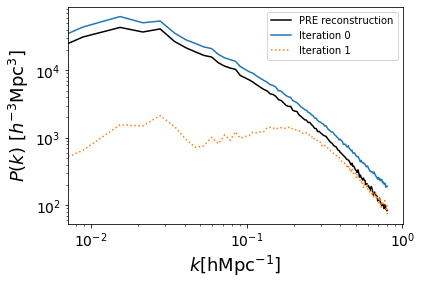

Iteration 1, Mean difference between Pks: 4109.08


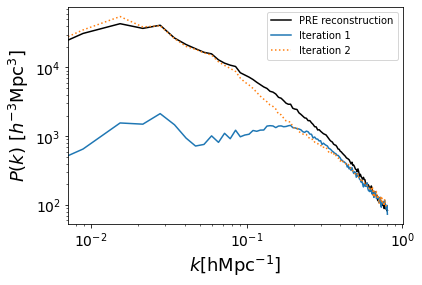

Iteration 2, Mean difference between Pks: 2574.74


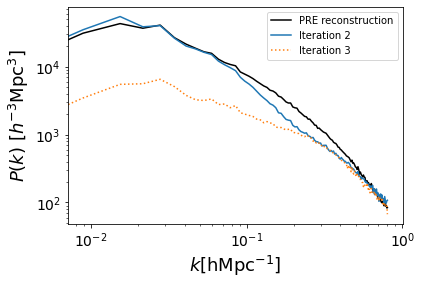

Iteration 3, Mean difference between Pks: 2265.60


In [7]:
# From redshift position
reconstructedQ, reconstructedQS = iteration(3, Length, Nc, zobs, zinit, galaxy, np.array([Length/2, Length/2, Length/2]), k, Pkg)#, delta_dm)

In [8]:
# Bias in real space
r = FFTPower(reconstructedQ, mode='1d')
Pkgreconr = r.power['power'].real - r.attrs['shotnoise']
bgreconr1 = np.mean(np.sqrt(Pkgreconr[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgreconr2 = np.mean(np.sqrt(Pkgreconr[mask]/Pkdm[mask]))
print('bias (real) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgreconr1, zinit,bgreconr2, zobs))

# Bias in redshift space
r = FFTPower(reconstructedQS, mode='1d')
Pkgrecons = r.power['power'].real - r.attrs['shotnoise']

bgrecons1 = np.mean(np.sqrt(Pkgrecons[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgrecons2 = np.mean(np.sqrt(Pkgrecons[mask]/Pkdm[mask]))

print('bias (redshift) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

bias (real) POST= 1.75(z=3.00),0.65(z=0.30)
bias (redshift) POST= 3.28(z=3.00),1.21(z=0.30)


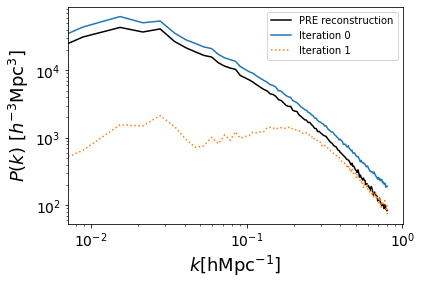

Iteration 1, Mean difference between Pks: 4109.08


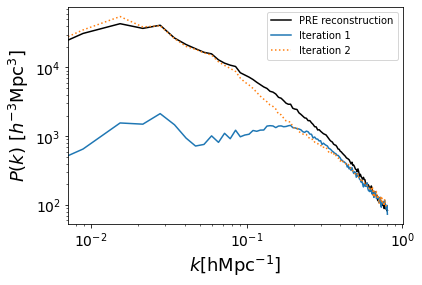

Iteration 2, Mean difference between Pks: 2574.74


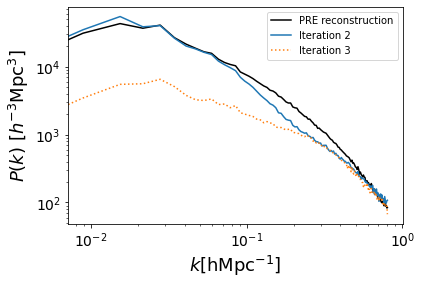

Iteration 3, Mean difference between Pks: 2265.60


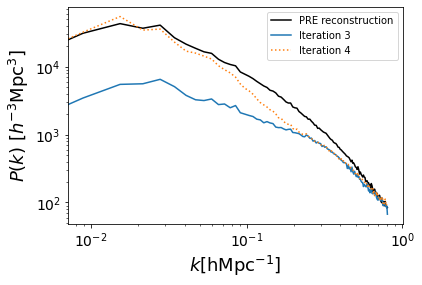

Iteration 4, Mean difference between Pks: 1929.34


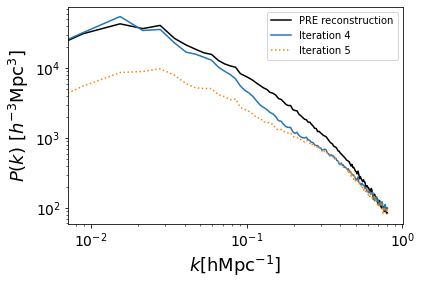

Iteration 5, Mean difference between Pks: 1695.43


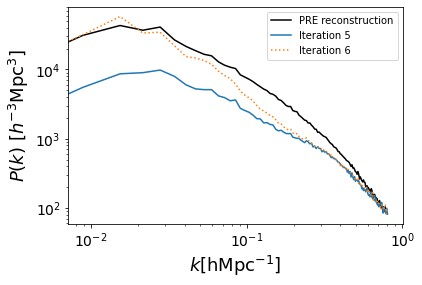

Iteration 6, Mean difference between Pks: 1591.65


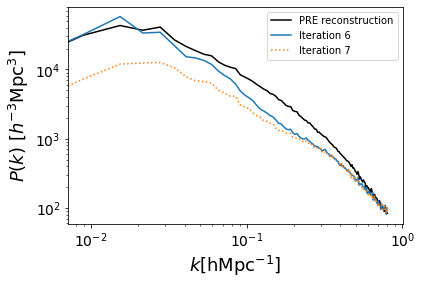

Iteration 7, Mean difference between Pks: 1400.74


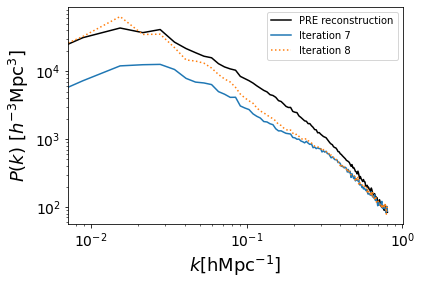

Iteration 8, Mean difference between Pks: 1417.59


In [11]:
# From real space position
reconstructedQ, reconstructedQS = iteration(8, Length, Nc, zobs, zinit, galaxy, np.array([Length/2, Length/2, Length/2]), k, Pkg)#, delta_dm)

In [10]:
# Bias in real space
r = FFTPower(reconstructedQ, mode='1d')
Pkgreconr = r.power['power'].real - r.attrs['shotnoise']
bgreconr1 = np.mean(np.sqrt(Pkgreconr[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgreconr2 = np.mean(np.sqrt(Pkgreconr[mask]/Pkdm[mask]))
print('bias (real) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgreconr1, zinit,bgreconr2, zobs))

# Bias in redshift space
r = FFTPower(reconstructedQS, mode='1d')
Pkgrecons = r.power['power'].real - r.attrs['shotnoise']

bgrecons1 = np.mean(np.sqrt(Pkgrecons[mask]*(D(zobs)**2)/(Pkdm[mask]*(D(zinit)**2))))

bgrecons2 = np.mean(np.sqrt(Pkgrecons[mask]/Pkdm[mask]))

print('bias (redshift) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

bias (real) POST= 2.14(z=3.00),0.79(z=0.30)
bias (redshift) POST= 3.39(z=3.00),1.26(z=0.30)


Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

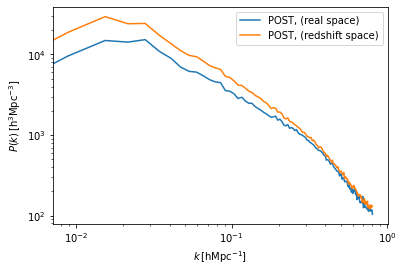

In [11]:
plt.loglog(k, Pkgreconr, label='POST, (real space)')
plt.loglog(k, Pkgrecons, label='POST, (redshift space)')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')